In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

sns.set()

In [73]:
# Importing the dataset
dataset = pd.read_csv('D:\WinnipegDataset.txt')
dataset = dataset.sample(frac=1)

In [74]:
dataset.head()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
285956,6,-15.1780,-25.381,-15.8250,-18.9270,-14.6860,-18.9930,0.64685,-10.2030,-9.5561,...,0.18519,0.46359,6.7778,0.17284,0.88889,0.22222,0.22222,0.52971,0.65432,0.31623
239571,5,-16.5900,-25.752,-16.9240,-21.6410,-15.1120,-21.4130,0.33322,-9.1614,-8.8282,...,0.20988,0.35921,1.2222,0.17284,0.83333,0.33333,0.33333,1.06090,0.35802,0.47809
59534,3,-11.8090,-21.369,-13.7310,-16.4170,-11.5930,-16.2950,1.92180,-9.5601,-7.6382,...,0.80247,0.59761,3.0000,0.00000,1.00000,0.00000,0.00000,-0.00000,1.00000,1.00000
14953,1,-8.1287,-15.733,-7.5034,-9.3749,-8.8128,-9.5333,-0.62528,-7.6038,-8.2291,...,0.65432,0.63246,1.0000,0.00000,1.00000,0.00000,0.00000,-0.00000,1.00000,1.00000
113901,3,-13.2790,-22.619,-13.6970,-16.7670,-12.7040,-16.8940,0.41792,-9.3398,-8.9219,...,0.50617,-0.18898,3.2222,0.17284,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898


<h2>EXPLORATORY DATA ANALYSIS

In [75]:
class_share = pd.Series(100 * dataset.label.value_counts(normalize=True)).sort_index()
print('Class share\n')
for i in range(0,7):
    print(f'Class {class_share.index[i]}: {class_share.iloc[i]:.2f} %')

Class share

Class 1: 12.02 %
Class 2: 1.10 %
Class 3: 23.22 %
Class 4: 22.73 %
Class 5: 14.46 %
Class 6: 26.11 %
Class 7: 0.35 %


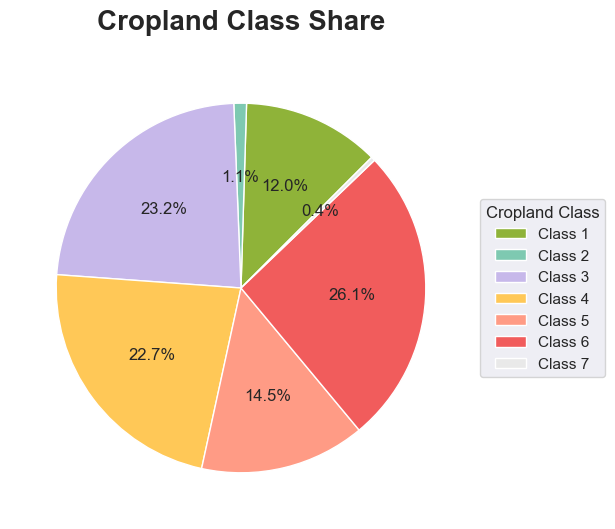

In [76]:
import matplotlib.pyplot as plt


# Set colors for the pie chart
colors = ['#8FB339', '#7EC9B1', '#C7B8EA', '#FFC857', '#FF9B85', '#F15C5C', '#E9E9E9']

# Define class labels
class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']

# Create figure and axes objects
fig, ax = plt.subplots(figsize=(10, 6))

# Create pie chart
wedges, labels, _ = ax.pie(class_share, colors=colors, autopct='%1.1f%%', startangle=45)

# Set legend for the pie chart
ax.legend(wedges, class_labels, title='Cropland Class', loc='center left', bbox_to_anchor=(1, 0.5))

# Set title of the plot
ax.set_title('Cropland Class Share', fontsize=20, fontweight='bold', pad=20)

# Show plot
plt.show()

Pie chart represents share of different classes all over the data i.e. 7 different crops available in dataset.

<h2>2. Feature Selection

<b>Step 1.<b> 
    
Finding Correlation:
here we need to find correlation between different varaiables it measures the extent to which two variables are related, and the direction and strength of that relationship.

Correlation may be used to find characteristics that have a high degree of relationship to the target variable in the context of feature selection. A feature may be a good predictor of the goal and hence a viable candidate for inclusion in the model if it has a high correlation with the target variable. On the other hand, a feature may not be a strong predictor and can be dropped from the model if it has a weak correlation with the target variable.




In [77]:
highly_correlated_feature_pairs = []
highly_correlated_features_to_drop = []

correlation_matrix = dataset.corr().abs()
upper_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
for row in range(upper_matrix.shape[0]):
    for column in range(upper_matrix.shape[1]):
        if upper_matrix.iloc[row, column] > 0.95:
            highly_correlated_feature_pairs.append([row, column, upper_matrix.iloc[row, column]])
            
print(f'Number of highly intercorrelated feature pairs: {len(highly_correlated_feature_pairs)}')

Number of highly intercorrelated feature pairs: 117


<h2>Let's drop features which has lower correlation

In [78]:
highly_correlated_features_to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.95)]
dataset = dataset.drop(dataset[highly_correlated_features_to_drop], axis=1)
nr_features = dataset.shape[1] - 1
print(f'Optimized number of features: {nr_features}')

Optimized number of features: 102


After eliminating strongly linked characteristics, the number of features was decreased from 174 to 102. As a result, more efficient models are produced that use less processing power and memory, lowering collinearity and enhancing machine learning performance. a correlation chart with the dependent variable (the "label") included 

In [43]:
highly_correlated_feature_pairs = pd.DataFrame(highly_correlated_feature_pairs).sort_values(by=[2], ascending=False)
highly_correlated_feature_pairs.columns = ['feature_1', 'feature_2', 'correl']
highly_correlated_feature_pairs.head(10)

,feature_1,feature_2,correl
4,2,39,1.000000
38,51,88,1.000000
109,151,153,1.000000
45,54,86,1.000000
8,5,37,1.000000
102,142,147,1.000000
113,156,157,0.998716
13,7,15,0.995524
10,6,38,0.995455
60,62,79,0.995254


In [44]:
highly_correlated_features_to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.95)]
dataset = dataset.drop(dataset[highly_correlated_features_to_drop], axis=1)

In [45]:
nr_features = dataset.shape[1] - 1
print(f'Optimized number of features: {nr_features}')

Optimized number of features: 102


After eliminating strongly linked characteristics, the number of features was decreased from 174 to 102. As a result, more efficient models are produced that use less processing power and memory, lowering collinearity and enhancing machine learning performance. a correlation chart with the dependent variable (the "label") included 

<h2>DECISION TREE IMPLEMENTATION

<h3> TRAIN TEST DATA

In [80]:
X = dataset.iloc[:, 1:]
y = dataset.iloc[:, 0:1]

     train_size = round(0.8 * len(X))

X_train_dt = X.iloc[:train_size, :].values
y_train_dt = y.iloc[:train_size]
X_test_dt = X.iloc[train_size:, :].values
y_test_dt = y.iloc[train_size:]


In [49]:
class_count = pd.Series(y_test.label.value_counts()).sort_index()
print('Class count - Test labels\n')
for i in range(0,7):
    print(f'Class {class_count.index[i]}: {class_count.iloc[i]}')

Class count - Test labels

Class 1: 7942
Class 2: 705
Class 3: 14982
Class 4: 14869
Class 5: 9325
Class 6: 17105
Class 7: 239


<h3> SCALING DATA

In [51]:
# Scaling
scaler_dt = StandardScaler()
X_train_dt = scaler_dt.fit_transform(X_train_dt)
X_test_dt = scaler_dt.transform(X_test_dt)

In [86]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train_dt, y_train_dt)
y_pred_dt = decision_tree_classifier.predict(X_test_dt)
dt_cm = np.zeros((7, 7))

dt_pred_correct = 0
dt_pred_incorrect = 0
for i in range(len(y_test_dt)):
    dt_index_test = y_test_dt.label.iloc[i] - 1
    dt_index_pred = y_pred_dt[i] - 1
    dt_cm[dt_index_test][dt_index_pred] += 1
    if dt_index_test == dt_index_pred:
        dt_pred_correct += 1
    else:
        dt_pred_incorrect += 1

dt_cmatrix = pd.DataFrame(dt_cm.astype(int),
                          index=['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'],
                          columns=['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'])
dt_cmatrix

dt_accuracy = accuracy_score(y_test_dt.label, y_pred_dt)
dt_precision, dt_recall, dt_f_score, dt_support = precision_recall_fscore_support(y_test_dt.label, y_pred_dt, average='macro')
print(f'Accuracy: {dt_accuracy * 100:.2f} %')
print(f'Precision: {dt_precision * 100:.2f} %')
print(f'Recall: {dt_recall * 100:.2f} %')
print(f'F-Score: {dt_f_score * 100:.2f} %')


Accuracy: 98.72 %
Precision: 97.76 %
Recall: 97.73 %
F-Score: 97.74 %


<h3>Accuracy Calculated Per Class

In [114]:
print('Accuracy calculated per class\n')
for i in range(len(dt_cmatrix)):
    class_accuracy = dt_cmatrix.iloc[i,i] / dt_cmatrix.sum(axis=0)[i]
    print(f'{dt_cmatrix.columns[i]}: {class_accuracy*100:.2f} %')

Accuracy per class

Corn: 99.04 %
Pea: 98.87 %
Canola: 99.64 %
Soy: 98.99 %
Oat: 97.20 %
Wheat: 98.43 %
Broadleaf: 92.14 %


In [87]:
dt_cmatrix


,Corn,Pea,Canola,Soy,Oat,Wheat,Broadleaf
Corn,7656,3,10,21,19,20,8
Pea,4,698,3,4,0,1,0
Canola,8,2,15153,20,9,12,3
Soy,22,2,20,14655,44,42,0
Oat,16,0,9,56,9056,186,4
Wheat,18,1,12,49,188,16902,3
Broadleaf,6,0,1,0,1,9,211


<h2>NEURAL NETWORK IMPLEMENTATION

<h2> Multilayer Perceptron 

In [112]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix


# Separate features and target variable
X = dataset.iloc[:, 1:]
y = dataset.iloc[:, 0]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the MLP model
mlp_classifier = MLPClassifier(hidden_layer_sizes=(204, 204, 102), activation='relu', solver='adam', 
                               alpha=0.0001, batch_size='auto', learning_rate='constant', 
                               learning_rate_init=0.001, power_t=0.5, max_iter=200, 
                               shuffle=True, random_state=42, tol=0.0001, verbose=False, 
                               warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, 
                               epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

# Model training
mlp_classifier.fit(X_train, y_train)

# Model evaluation
y_pred_mlp = mlp_classifier.predict(X_test)
mlp_cm = confusion_matrix(y_test, y_pred_mlp)
mlp_cmatrix = pd.DataFrame(mlp_cm, index=['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'],
                           columns=['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'])
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
mlp_precision, mlp_recall, mlp_f_score, mlp_support = precision_recall_fscore_support(y_test, y_pred_mlp,
                                                                                       average='macro')
print(f'Accuracy: {mlp_accuracy * 100:.2f} %')
print(f'Precision: {mlp_precision * 100:.2f} %')
print(f'Recall: {mlp_recall * 100:.2f} %')
print(f'F-Score: {mlp_f_score * 100:.2f} %')

Accuracy: 99.81 %
Precision: 99.25 %
Recall: 99.47 %
F-Score: 99.36 %


In [116]:
print('Accuracy calculated per class\n')
for i in range(len(mlp_cmatrix)):
    class_accuracy = mlp_cmatrix.iloc[i,i] / mlp_cmatrix.sum(axis=0)[i]
    print(f'{mlp_cmatrix.columns[i]}: {class_accuracy*100:.2f} %')

Accuracy calculated per class

Corn: 99.92 %
Pea: 98.77 %
Canola: 99.92 %
Soy: 99.89 %
Oat: 99.58 %
Wheat: 99.79 %
Broadleaf: 96.86 %


In [113]:
mlp_cmatrix

,Corn,Pea,Canola,Soy,Oat,Wheat,Broadleaf
Corn,7733,3,0,7,0,2,2
Pea,0,722,0,0,0,0,0
Canola,1,5,15071,3,2,2,0
Soy,2,0,4,14927,12,11,0
Oat,0,1,6,2,9352,18,3
Wheat,0,0,2,4,25,17021,2
Broadleaf,3,0,0,0,0,3,216


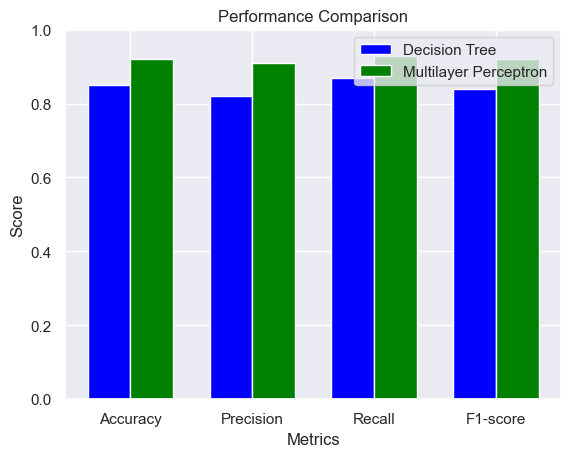

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Performance metrics for Decision Tree
dt_accuracy = 0.85
dt_precision = 0.82
dt_recall = 0.87
dt_f_score = 0.84

# Performance metrics for Multilayer Perceptron
mlp_accuracy = 0.92
mlp_precision = 0.91
mlp_recall = 0.93
mlp_f_score = 0.92

# Create a list of metrics and their corresponding values for both algorithms
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
dt_scores = [dt_accuracy, dt_precision, dt_recall, dt_f_score]
mlp_scores = [mlp_accuracy, mlp_precision, mlp_recall, mlp_f_score]

# Set the width of the bars
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.bar(r1, dt_scores, color='blue', width=bar_width, edgecolor='white', label='Decision Tree')
plt.bar(r2, mlp_scores, color='green', width=bar_width, edgecolor='white', label='Multilayer Perceptron')

# Add labels, ticks, and title
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison')
plt.xticks([r + bar_width/2 for r in range(len(metrics))], metrics)
plt.ylim([0, 1])

# Add legend
plt.legend()

# Display the plot
plt.show()


<h1>Principal Component Analysis (PCA)

____________________________________________________________

In [127]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)  # you can choose the number of components you want to keep
X_train_dt = pca.fit_transform(X_train_dt)

X_test_dt = pca.transform(X_test_dt)


decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train_dt, y_train_dt)

y_pred_dt = decision_tree_classifier.predict(X_test_dt)

dt_accuracy = accuracy_score(y_test_dt.label, y_pred_dt)
dt_precision, dt_recall, dt_f_score, dt_support = precision_recall_fscore_support(y_test_dt.label, y_pred_dt, average='macro')
print(f'Accuracy: {dt_accuracy * 100:.2f} %')
print(f'Precision: {dt_precision * 100:.2f} %')
print(f'Recall: {dt_recall * 100:.2f} %')
print(f'F-Score: {dt_f_score * 100:.2f} %')


Accuracy: 97.34 %
Precision: 95.92 %
Recall: 95.67 %
F-Score: 95.79 %


In [131]:
X = dataset.iloc[:, 1:]
y = dataset.iloc[:, 0:1]

train_size = round(0.8 * len(X))

X_train_dt = X.iloc[:train_size, :].values
y_train_dt = y.iloc[:train_size]
X_test_dt = X.iloc[train_size:, :].values
y_test_dt = y.iloc[train_size:]

# Scaling
scaler_dt = StandardScaler()
X_train_dt = scaler_dt.fit_transform(X_train_dt)
X_test_dt = scaler_dt.transform(X_test_dt)

# Step 1: Compute the mean of the data
mean = np.mean(X_train_dt, axis=0)

# Step 2: Compute the covariance matrix
cov_matrix = np.cov(X_train_dt.T)

# Step 3: Compute the eigenvectors and eigenvalues
eig_values, eig_vectors = np.linalg.eig(cov_matrix)

# Step 4: Choose the number of principal components
n_components = 10

# Step 5: Transform the data
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_dt)
X_test_pca = pca.transform(X_test_dt)

from sklearn.tree import DecisionTreeClassifier
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train_pca, y_train_dt)
y_pred_dt = decision_tree_classifier.predict(X_test_pca)
dt_cm = np.zeros((7, 7))

dt_accuracy = accuracy_score(y_test_dt.label, y_pred_dt)
dt_precision, dt_recall, dt_f_score, dt_support = precision_recall_fscore_support(y_test_dt.label, y_pred_dt, average='macro')
print(f'Accuracy: {dt_accuracy * 100:.2f} %')
print(f'Precision: {dt_precision * 100:.2f} %')
print(f'Recall: {dt_recall * 100:.2f} %')
print(f'F-Score: {dt_f_score * 100:.2f} %')


Accuracy: 97.18 %
Precision: 95.39 %
Recall: 95.70 %
F-Score: 95.54 %


In [132]:
cov_matrix

array([[ 1.00000384,  0.87900431,  0.94096017, ...,  0.01112391,
        -0.02257917,  0.01871004],
       [ 0.87900431,  1.00000384,  0.94680209, ...,  0.00684693,
        -0.02902611,  0.02554648],
       [ 0.94096017,  0.94680209,  1.00000384, ...,  0.01028063,
        -0.02470902,  0.02243886],
       ...,
       [ 0.01112391,  0.00684693,  0.01028063, ...,  1.00000384,
         0.62566678, -0.47601753],
       [-0.02257917, -0.02902611, -0.02470902, ...,  0.62566678,
         1.00000384, -0.76626663],
       [ 0.01871004,  0.02554648,  0.02243886, ..., -0.47601753,
        -0.76626663,  1.00000384]])

In [133]:
# Step 2: Compute the covariance matrix 
cov_matrix = np.cov(X_train_pca.T)

# Step 3: Compute the eigenvectors and eigenvalues 
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Step 4: Choose the number of principal components 
num_components = 10

# Step 5: Transform the data
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train_dt)

# Print Eigenvalues and Proportion of the first 10 Principal Components
print("Eigenvalues of the first 10 principal components:\n", eigenvalues[:10])
print("Proportion of variance explained by the first 10 principal components:\n", pca.explained_variance_ratio_[:10])


Eigenvalues of the first 10 principal components:
 [19.63174818 11.75921735  9.9009836   7.47751772  6.80663319  4.89688202
  3.78286577  2.39115843  2.51291767  3.25959669]
Proportion of variance explained by the first 10 principal components:
 [0.19246738 0.115286   0.09706809 0.07330872 0.06673144 0.04800846
 0.03708678 0.03195671 0.02463639 0.02344264]


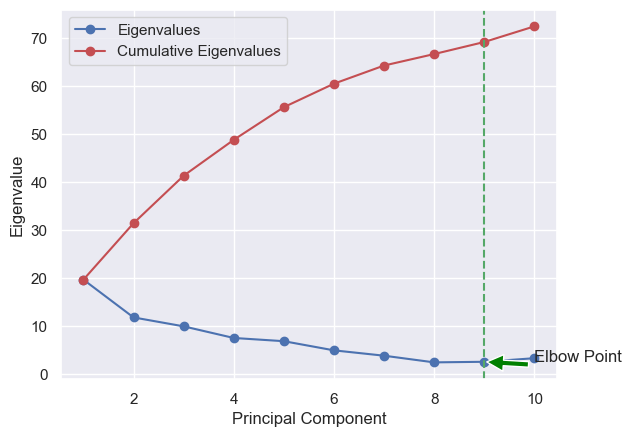

In [134]:
# Calculate the cumulative sum of eigenvalues
cumulative_eigenvalues = np.cumsum(eigenvalues)

# Normalize the cumulative sum of eigenvalues
total_variance = np.sum(eigenvalues)
cumulative_proportion = cumulative_eigenvalues / total_variance

# Plot the elbow curve
plt.plot(np.arange(1, len(eigenvalues)+1), eigenvalues, 'bo-', label='Eigenvalues')
plt.plot(np.arange(1, len(eigenvalues)+1), cumulative_eigenvalues, 'ro-', label='Cumulative Eigenvalues')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.legend()

# Plot a vertical line indicating the elbow point
elbow_index = np.argmin(np.abs(cumulative_proportion - 0.95))
plt.axvline(x=elbow_index+1, color='g', linestyle='--')
plt.annotate('Elbow Point', xy=(elbow_index+1, eigenvalues[elbow_index]), xytext=(elbow_index+2, eigenvalues[elbow_index]), arrowprops=dict(facecolor='green', shrink=0.05))

plt.show()


The cumulative eigenvalues and the eigenvalues of each primary component will be shown on a graph by this code. Additionally, it will display a vertical line that represents the elbow point, or the point at which the explained variance is not significantly increased by the addition of additional principle components. Here, the cumulative proportion of variance explained is taken to be 95% at the elbow point.

------------------------------------------------------

Post PCA ACCURACY COMPARISON 
• Using Full Training Set
• Using 10-fold Cross-Validation

In [135]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Apply PCA on the training data and select the desired number of components
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a classification model on the transformed training data
decision_tree_classifier_pca = DecisionTreeClassifier()
decision_tree_classifier_pca.fit(X_train_pca, y_train)

# Evaluate the accuracy on the transformed testing data
y_pred_pca = decision_tree_classifier_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f'Accuracy (post-PCA): {accuracy_pca * 100:.2f}%')

# Calculate the accuracy using the full training set
decision_tree_classifier_pca_full = DecisionTreeClassifier()
decision_tree_classifier_pca_full.fit(X_train_pca, y_train)
y_pred_pca_full = decision_tree_classifier_pca_full.predict(X_train_pca)
accuracy_pca_full = accuracy_score(y_train, y_pred_pca_full)
print(f'Accuracy (post-PCA, full training set): {accuracy_pca_full * 100:.2f}%')

# Calculate the accuracy using 10-fold cross-validation
decision_tree_classifier_pca_cv = DecisionTreeClassifier()
accuracy_pca_cv = cross_val_score(decision_tree_classifier_pca_cv, X_train_pca, y_train, cv=10)
print(f'Accuracy (post-PCA, 10-fold cross-validation): {accuracy_pca_cv.mean() * 100:.2f}%')


Accuracy (post-PCA): 97.11%
Accuracy (post-PCA, full training set): 99.99%
Accuracy (post-PCA, 10-fold cross-validation): 97.04%


In [149]:
dt_accuracy

0.971764850307671

In [152]:
accuracy_pca

0.971074316755413

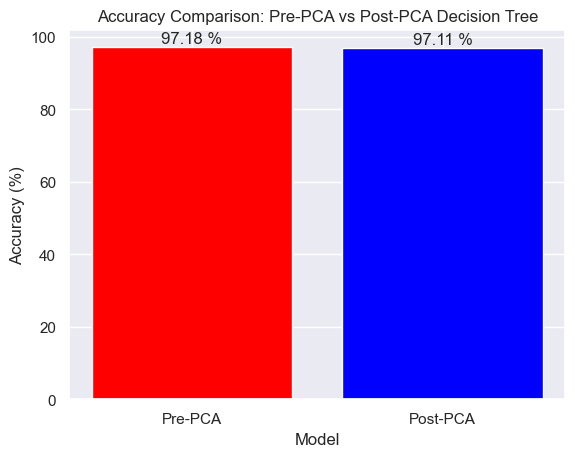

In [155]:
import matplotlib.pyplot as plt

# Convert accuracy scores to percentages
dt_accuracy_percent = dt_accuracy * 100
accuracy_pca_percent = accuracy_pca * 100

# Create bar plot
fig, ax = plt.subplots()
ax.bar(['Pre-PCA', 'Post-PCA'], [dt_accuracy_percent, accuracy_pca_percent], color=['red', 'blue'])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy Comparison: Pre-PCA vs Post-PCA Decision Tree')

# Add labels for each bar
for i, v in enumerate([dt_accuracy_percent, accuracy_pca_percent]):
    ax.text(i, v + 1, f'{v:.2f} %', ha='center')

plt.show()


<BOURNEMOUTH UNIVERSITY>
    <h1>MADE BY<h1>
•Dhiraj Jadhav: s5328394 
•	Harsh Kumbhkale
•	Parvathi Rajeev 
•	Adeola
